In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer,IBMQ
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType


In [3]:
from qiskit.providers.ibmq import least_busy
IBMQ.save_account('22f33f85e8f8144e9fa2b2dffa0b3a2fccf8396564670db4b52c0d00250263e47799f278c9584ebdb98964a655e806e4ff05fe73bd913f3496d3345a0abe43bd')
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q-education')
provider.backends()
backends = provider.backends(filters = lambda x:x.configuration().n_qubits >= 4 and not x.configuration().simulator
                             and x.status().operational==True)
backend = least_busy(backends)
print(backend)

configrc.store_credentials:WARNING:1970-01-01 09:44:17,458: Credentials already present. Set overwrite=True to overwrite.
/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/hzr/anaconda3/en

ibmq_lima


In [12]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(1.0,4.25,0.25)
vqe_energies = []
hf_energies = []
exact_energies = []
real_vqe_energies = []



In [13]:

for i,d in enumerate(distances):
  print("step",i)

  #setup exp
  driver = PySCFDriver(molecule.format(d/2), basis='sto3g',)
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                         two_qubit_reduction=True, freeze_core=True,
                         orbital_reduction=[-3,-2])
  
  qubit_op, aux_ops = operator.run(qmolecule)

  #exact res
  exact_result = NumPyMinimumEigensolver(qubit_op,aux_operators=aux_ops).run()
  exact_result = operator.process_algorithm_result(exact_result)

  #VQE
  optimizer = SLSQP(maxiter=1000)
  initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                               operator.molecule_info['num_particles'],
                               qubit_mapping=operator._qubit_mapping,
                               two_qubit_reduction=operator._two_qubit_reduction)
                               
  var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction=operator._two_qubit_reduction)
  
  algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)

  vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
  vqe_result = operator.process_algorithm_result(vqe_result)

  # VQE Real Machine
  # real_vqe_result = algo.run(QuantumInstance(backend))
  # real_vqe_result = operator.process_algorithm_result(real_vqe_result)


  exact_energies.append(exact_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)
  # real_vqe_energies.appen(real_vqe_result.energy)



step 0


<ipython-input-13-76ebe99db2d6>:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12


In [14]:
algo.get_optimal_circuit().draw(with_layout=False)

┌───┐┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
q_0: ┤ X ├┤0             ├┤0             ├┤0             ├┤0             ├»
     ├───┤│              ││              ││              ││              │»
q_1: ┤ X ├┤1             ├┤1             ├┤1             ├┤1             ├»
     └───┘│  Evolution^1 ││  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
q_2: ─────┤2             ├┤2             ├┤2             ├┤2             ├»
          │              ││              ││              ││              │»
q_3: ─────┤3             ├┤3             ├┤3             ├┤3             ├»
          └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├
«     │              ││              ││              ││              │
«q_1: ┤1             ├┤1             ├┤1             ├┤1             ├
«     │  Evolution^1 ││  Evolution^1 ││  Evolution^1 ││  Evolution^1 │
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├
«     │              ││              ││              ││              │
«q_3: ┤3             ├┤3             ├┤3             ├┤3             ├
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘

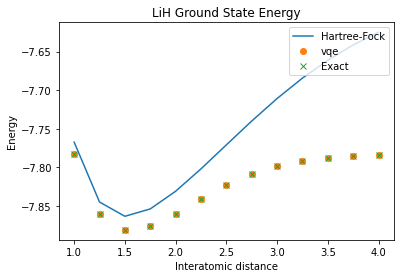

In [18]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='vqe')
pylab.plot(distances, exact_energies, 'x', label='Exact')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')
